# Introduction

In the [[Stokes equation]] notebook I plotted the flow field generated by a stokeslet, a dipole, and a multipole.

In this notebook, I play around with the openCL implementation. Mainly, to learn OpenCL.
The following implementation  allows  evaluation of up to 1.000.000 stokeslets on a 4500 nodes grid in 4s
(on Intel® Core™ i5-4210U CPU @ 1.70GHz × 4, Haswell gpu, lenovo ideapad u330)

As a reminder, the Stokes equation is
$$ \nabla \mathbf p +\mu \nabla^2 \mathbf u=\mathbf f.$$
The stokeslet gives the flow field $\mathbf u$ in $\mathbf r$ provided the force $\mathbf f(\mathbf r)=\delta(\mathbf r - \mathbf r_0)\mathbf f$ acts on the fluid in $\mathbf r_0$. 
Given the boundary condition: $\mathbf u(\infty)=0$, the stokeslet is the linear operator:
$$ O=\frac{4 \pi}{\mu}\frac{1}{\lVert \mathbf r\rVert }\left[ \mathbb I + \mathbf r \mathbf r^T\right]$$
where $\mathbf r$ is the vector between $r_0$ and the point where we compute the fluid.



## Python definitions

In [1]:
import numpy as np
import pylab as pl
import pyopencl as cl
import pyopencl.array as cl_array
from pyopencl.elementwise import ElementwiseKernel
import seaborn as sns
import os
# from IPython.html.widgets import interact,interact_manual
from ipywidgets import interact
sns.set_style("white")
%matplotlib inline

In [2]:
os.environ['PYOPENCL_CTX']='0'
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

In [3]:
x,X,y,Y=-5,5,-5,5 #our space
dx,dy=.15,.15       #discretisation
mX,mY=np.meshgrid(np.arange(x,X,dx),np.arange(y,Y,dy))
# list of nodes in the meshgrid. NOTE the dtype! This array will go in the device
nodes=np.asarray([[jy,jx] for jx in np.arange(x,X,dx) for jy in np.arange(y,Y,dy)],dtype=np.float32)
# create the first array to the device to be the same as nodes. 
# the suffix _d indicates device memory (in this noteboook)
nodes_d=cl_array.to_device(queue,nodes)
print len(nodes)," nodes"

4489  nodes


# Flow of a point force
## CPU

In [4]:
def CPUstokeslet(f,r0,mX,mY):
    Id=np.array([[1,0],[0,1]])
    r=np.array([mX-r0[0],mY-r0[1]])

    Idf=np.dot(Id,f)
    
    rTf=(r*f[:,np.newaxis,np.newaxis]).sum(axis=0)
    rrTf=(r*rTf[np.newaxis,])
    modr=(r[0]**2+r[1]**2+.01)**.5
    
    u,v=Idf[:,np.newaxis,np.newaxis]/modr[np.newaxis]+rrTf/modr**3.
    return u,v

## openCL

In [37]:
# one test force in 2D
# these are array of 2 components just to write one single kernel that handles 1 force, as well as many forces
r0=np.array([[0,3],],dtype=np.float32)            # position of the force
f=np.array([[-1,-.5],],dtype=np.float32)             # direction of the force

# or see this https://github.com/pyopencl/pyopencl/blob/master/examples/demo_mandelbrot.py
KernelN="""
// This is openCL
// i is defined by the ElementwiseKernel function of pyopencl
// as the i-th shader
//
// nodes,out,r0, and force are float2 * types, defined in the elementwisekernel (see below)
// N is int defined as the others
// 

// and now  compute the velocity produced by all stokeslet
// and cumulate to out[i] because stokes equation is linear


// local variable as cumulant (thanks Sebastian)
float2 a = 0.;
//float2(0.0);

for (int j=0;j<N;j++){
    float2 f= force[j];

    float2 e=nodes[i]-r0[j];
    // lenght and dot are defined somewhere -- I found it on wikipage about cg
    
    
    float n=length(e);
    e/=n;
    
    float2 RRTF= e*dot(e,f);
    
    // in this test, let's skip the 4pi/mu prefactor
    a+=(f+RRTF)/n;
    
out[i]=a;
    
}
"""

stokesletN = ElementwiseKernel(ctx,
    "float2 *nodes, float2 *out, float2 * r0, float2 * force,const int N",
    KernelN,
    "stokesletN"
)

# output array
out_d = cl.array.empty_like(nodes_d)
# input parameters
r0_d=cl_array.to_device(queue,r0)
f_d=cl_array.to_device(queue,f)

# compute
stokesletN(nodes_d,out_d,r0_d,f_d,1)

#get the data
out=out_d.get()

## Monopole

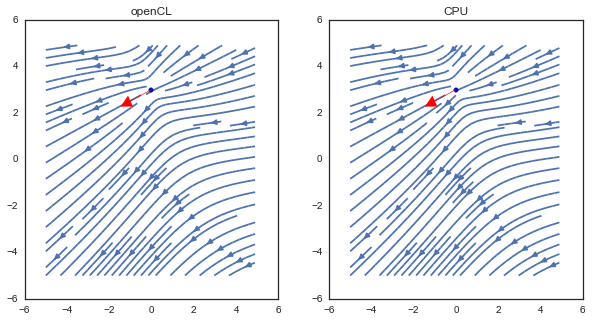

In [31]:
fig,(ax,bx)=pl.subplots(1,2,figsize=(10,5))

ax.set_title("openCL")
bx.set_title("CPU")

SIDE=int(out.T.shape[1]**.5)
u,v=out.T
u=u.reshape((SIDE,SIDE))
v=v.reshape((SIDE,SIDE))
ax.streamplot(mX,mY,u,v)
ax.scatter(r0[0,0],r0[0,1])
ax.arrow(r0[0,0],r0[0,1],f[0,0],f[0,1],head_width=0.5, head_length=0.5, fc='r', ec='r')


u,v=CPUstokeslet(f[0],r0[0],mX,mY)
bx.streamplot(mX,mY,u,v)
bx.scatter(r0[0,0],r0[0,1])
bx.arrow(r0[0,0],r0[0,1],f[0,0],f[0,1],head_width=0.5, head_length=0.5, fc='r', ec='r')

## A couple of functions 
The following plots are interactive.
Download the ipython notebook and run it 

In [10]:
def complex_flow(N=1300):
    r0=np.random.rand(N,2).astype(np.float32)*10-5
    f=np.random.rand(N,2).astype(np.float32)-.5

    out_d = cl.array.empty_like(nodes_d)
    r0_d=cl_array.to_device(queue,r0)
    f_d=cl_array.to_device(queue,f)
    stokesletN(nodes_d,out_d,r0_d,f_d,N)

    out=out_d.get()
    SIDE=int(out.T.shape[1]**.5)
    u,v=out.T.reshape(2,SIDE,SIDE)
    pl.figure(figsize=(7,7))
    pl.quiver(mX,mY,u,v,color="#cccccc")
    pl.streamplot(mX,mY,u,v,color='r')
    pl.quiver(r0[:,1],r0[:,0],f[:,0],f[:,1])
    
def rotate_flow(alpha=5):
    alpha=alpha/360.*2*np.pi
    r0=np.asarray([[0,0],]).astype(np.float32)
    f=np.asarray([[np.cos(alpha),np.sin(alpha)],],).astype(np.float32)/10.

    out_d = cl.array.empty_like(nodes_d)
    r0_d=cl_array.to_device(queue,r0)
    f_d=cl_array.to_device(queue,f)
    stokesletN(nodes_d,out_d,r0_d,f_d,1)

    out=out_d.get()
    SIDE=int(out.T.shape[1]**.5)
    u,v=out.T.reshape(2,SIDE,SIDE)
#     pl.figure(figsize=(7,7))
    pl.quiver(mX,mY,u,v,color="#cccccc")
    pl.streamplot(mX,mY,u,v,color='r')
    pl.quiver(r0[:,0],r0[:,1],f[:,0],f[:,1])

## Rotate the force direction
to check that it is actually ok

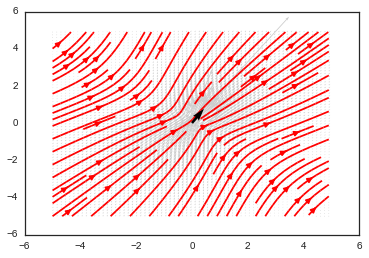

In [11]:
interact(rotate_flow,alpha=(0,360,5))

## Complex flow of many stokeslets
N is the number of random stokeslets  

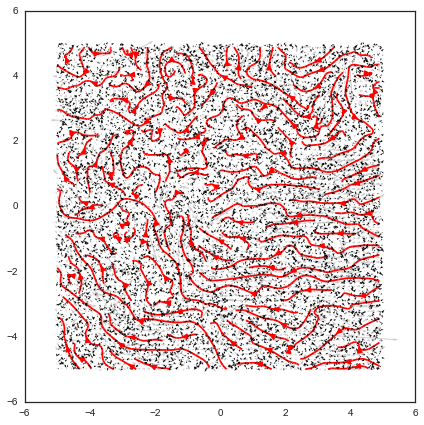

In [119]:
interact(complex_flow,N=(1,10000,10))

## Timing

In [33]:
def test_flow(N=5):
    r0=np.random.rand(N,2).astype(np.float32)*10-5
    f=np.random.rand(N,2).astype(np.float32)-.5

    out_d = cl.array.empty_like(nodes_d)
    r0_d=cl_array.to_device(queue,r0)
    f_d=cl_array.to_device(queue,f)
    stokesletN(nodes_d,out_d,r0_d,f_d,N)

    out=out_d.get()
    SIDE=int(out.T.shape[1]**.5)
    u,v=out.T.reshape(2,SIDE,SIDE)

In [36]:
%%timeit

test_flow(1500)

10 loops, best of 3: 25 ms per loop


In [26]:
%%time

test_flow(100000)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 829 ms


In [15]:
%%time

test_flow(1000000)

CPU times: user 72 ms, sys: 24 ms, total: 96 ms
Wall time: 4.34 s
